In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Mental_Foreman/Mental_Foramen_FF.zip" -d "/content/mental_foreman"

Streaming output truncated to the last 5000 lines.
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (168).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (168).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (492).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (492).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (304).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (304).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (373).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (373).jpg  
  inflating: /content/mental_foreman/Mental_Foramen_FF/segmented_image/SI0 (236).jpg  
  inflating: /content/mental_foreman/__MACOSX/Mental_Foramen_FF/segmented_image/._SI0 (236).jpg  
  inflating: /content/me

In [ ]:
# Resize images

def resizeImages(resize_shape, path):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images = np.asarray(images)
    # images = images[:,:,0]
    for i in range(1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        # print('image shape:',img.size)
        img = np.asarray(img)
        # print('image array shape:',img.shape)
        # img=img[:,:,0]
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],3))#3
    return images, sizes

In [ ]:
path_original = '/content/mental_foreman/Mental_Foramen_FF/ORIGINAL/'

X,X_sizes = resizeImages((256,256), path=path_original)

In [ ]:
def resizeMasks(resize_shape, path):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images = np.asarray(images)
    # images = images[:,:,0]
    for i in range(1,len(dirs)):
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        # print('image shape:',img.size)
        img = np.asarray(img)
        # print('image array shape:',img.shape)
        # img=img[:,:,0]
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images, sizes

In [ ]:
path_mask = '/content/mental_foreman/Mental_Foramen_FF/masked/'
Y,Y_sizes = resizeMasks((256,256), path=path_mask)

In [ ]:
X=np.float32(X/255)
Y=np.float32(Y/255)

In [ ]:
x_train=X[:500,:,:,:]
y_train=Y[:500,:,:,:]
x_test=X[500:,:,:,:]
y_test=Y[500:,:,:,:]

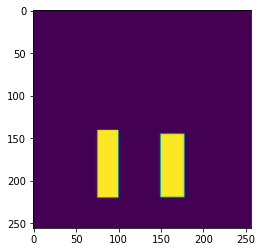

In [ ]:
plt.imshow(y_train[0][:,:,0])

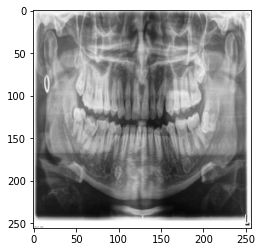

In [ ]:
plt.imshow(x_train[0])

In [ ]:
"""
ResUNet architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class ResUnet:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        def conv_block(x, n_filter):
            x_init = x

            ## Conv 1
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)
            ## Conv 2
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (3, 3), padding="same")(x)
            ## Conv 3
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Conv2D(n_filter, (1, 1), padding="same")(x)

            ## Shortcut
            s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
            s = BatchNormalization()(s)

            ## Add
            x = Add()([x, s])
            return x

        def resnet_block(x, n_filter, pool=True):
            x1 = conv_block(x, n_filter)
            c = x1

            ## Pooling
            if pool == True:
                x = MaxPooling2D((2, 2), (2, 2))(x1)
                return c, x
            else:
                return c

        n_filters = [16, 32, 64, 96, 128]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        ## Encoder
        c1, p1 = resnet_block(c0, n_filters[0])
        c2, p2 = resnet_block(p1, n_filters[1])
        c3, p3 = resnet_block(p2, n_filters[2])
        c4, p4 = resnet_block(p3, n_filters[3])

        ## Bridge
        b1 = resnet_block(p4, n_filters[4], pool=False)
        b2 = resnet_block(b1, n_filters[4], pool=False)

        ## Decoder
        d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
        #d1 = UpSampling2D((2, 2))(b2)
        d1 = Concatenate()([d1, c4])
        d1 = resnet_block(d1, n_filters[3], pool=False)

        d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
        #d2 = UpSampling2D((2, 2))(d1)
        d2 = Concatenate()([d2, c3])
        d2 = resnet_block(d2, n_filters[2], pool=False)

        d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
        #d3 = UpSampling2D((2, 2))(d2)
        d3 = Concatenate()([d3, c2])
        d3 = resnet_block(d3, n_filters[1], pool=False)

        d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
        #d4 = UpSampling2D((2, 2))(d3)
        d4 = Concatenate()([d4, c1])
        d4 = resnet_block(d4, n_filters[0], pool=False)

        ## output
        outputs = Conv2D(1, (1, 1), padding="same")(d4)
        outputs = BatchNormalization()(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
"""
ResUNet++ architecture in Keras TensorFlow
"""
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=256):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# from data_generator import DataGen
# from unet import Unet
# from resunet import ResUnet
# from m_resunet import ResUnetPlusPlus
#from metrics import dice_coef, dice_loss


In [ ]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * binary_crossentropy(y_true, y_pred) + 0.8 * dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
# © 2022 GitHub, Inc.
# Terms
# Priva

In [ ]:
image_size = 256
batch_size = 4
lr = 1e-4
# epochs = 20

arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model() 
optimizer = Nadam(lr)
metrics = ['accuracy', Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#val_loss


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# ResUnet++
model.fit(x_train,y_train,batch_size=4,epochs=200,verbose=1)

Epoch 1/200
125/125 [==============================] - 55s 196ms/step - loss: 0.5079 - accuracy: 0.9089 - recall: 0.9350 - precision: 0.4107 - dice_coef: 0.4921 - mean_io_u: 0.7083
Epoch 2/200
125/125 [==============================] - 25s 198ms/step - loss: 0.2943 - accuracy: 0.9626 - recall: 0.8772 - precision: 0.7247 - dice_coef: 0.7057 - mean_io_u: 0.7644
Epoch 3/200
125/125 [==============================] - 25s 199ms/step - loss: 0.2282 - accuracy: 0.9692 - recall: 0.8210 - precision: 0.8107 - dice_coef: 0.7718 - mean_io_u: 0.7922
Epoch 4/200
125/125 [==============================] - 25s 201ms/step - loss: 0.2002 - accuracy: 0.9712 - recall: 0.7980 - precision: 0.8443 - dice_coef: 0.7998 - mean_io_u: 0.8034
Epoch 5/200
125/125 [==============================] - 25s 203ms/step - loss: 0.1854 - accuracy: 0.9722 - recall: 0.7926 - precision: 0.8601 - dice_coef: 0.8146 - mean_io_u: 0.8099
Epoch 6/200
125/125 [==============================] - 25s 203ms/step - loss: 0.1680 - accuracy

In [ ]:
model.save('saved_weights/ResUnetPlusPlus.h5')

In [ ]:
predict_img = model.predict(x_test)

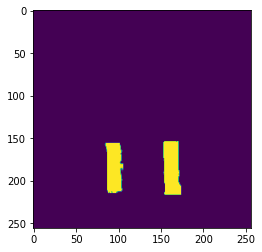

In [ ]:
plt.imshow(predict_img[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_img, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

dice_average : tf.Tensor(0.7441827, shape=(), dtype=float32)


In [ ]:
m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_img)
print("Mean IoU :",m.result().numpy())

Mean IoU : 0.756963


# ***`ResUnet architecture`***

In [ ]:
# ResUnet architecture

image_size = 256
batch_size = 4
lr = 1e-4
# epochs = 10

arch = ResUnet(input_size=image_size)
model = arch.build_model()
optimizer = Nadam(lr)
metrics = ['accuracy', Recall(), Precision(), dice_coef, MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#val_loss
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

In [ ]:
model.fit(x_train,y_train,batch_size=4,epochs=200,verbose=1)

Epoch 1/200
125/125 [==============================] - 39s 104ms/step - loss: 0.8562 - accuracy: 0.7161 - recall: 0.9395 - precision: 0.1605 - dice_coef: 0.1438 - mean_io_u: 0.4818
Epoch 2/200
125/125 [==============================] - 13s 106ms/step - loss: 0.8351 - accuracy: 0.8774 - recall: 0.9849 - precision: 0.3358 - dice_coef: 0.1649 - mean_io_u: 0.4818
Epoch 3/200
125/125 [==============================] - 13s 105ms/step - loss: 0.8309 - accuracy: 0.9055 - recall: 0.9887 - precision: 0.4091 - dice_coef: 0.1691 - mean_io_u: 0.4818
Epoch 4/200
125/125 [==============================] - 13s 106ms/step - loss: 0.8283 - accuracy: 0.9181 - recall: 0.9901 - precision: 0.4532 - dice_coef: 0.1717 - mean_io_u: 0.4818
Epoch 5/200
125/125 [==============================] - 13s 108ms/step - loss: 0.8262 - accuracy: 0.9256 - recall: 0.9905 - precision: 0.4842 - dice_coef: 0.1738 - mean_io_u: 0.4818
Epoch 6/200
125/125 [==============================] - 14s 109ms/step - loss: 0.8248 - accuracy

In [ ]:
model.save('saved_weights/ResUnet.h5')

In [ ]:
# model.load_weights()

In [ ]:
predict_img1 = model.predict(x_test)

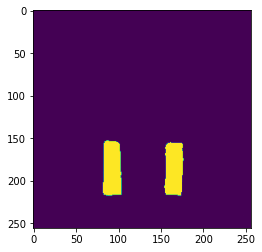

In [ ]:
plt.imshow(predict_img1[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_img1, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_img1)
print("Mean IoU :",m.result().numpy())

dice_average : tf.Tensor(0.5380217, shape=(), dtype=float32)
Mean IoU : 0.4863704


In [ ]:
!pip3 install keras_unet_collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ***Unet++ Architecture***

In [ ]:
# Model: Unet++2d

model_Unet_plus = models.unet_plus_2d((256, 256, 3), filter_num=[16,32,64, 128, 256], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone=None, weights=None,freeze_backbone=True, freeze_batch_norm=True,
                           name='unet_plus')

model_Unet_plus.compile(loss=dice_loss, optimizer='adam', 
              metrics=['accuracy', losses.dice_coef, Recall(), Precision(), MeanIoU(num_classes=2)])#losses.dice

print(model_Unet_plus.summary())

Model: "unet_plus_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 unet_plus_down0_0 (Conv2D)  (None, 256, 256, 16)      432       
                                                                 
 unet_plus_down0_0_bn (Batch  (None, 256, 256, 16)     64        
 Normalization)                                                  
                                                                 
 unet_plus_down0_0_activatio  (None, 256, 256, 16)     0         
 n (ReLU)                                                        
                                                                 
 unet_plus_down0_1 (Conv2D)  (None, 256, 256, 16)      2304      
                                                                 
 unet_plus_down0_1_bn (Batch  (None, 256, 256, 16) 

In [ ]:
callbacks= [tf.keras.callbacks.EarlyStopping(patience=3, monitor=dice_coef, mode='max')]#monitor='val_loss'
Unet_plus_history = model_Unet_plus.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    #validation_split=0.1, 
                    shuffle=False,
                    epochs=200, callbacks=callbacks)


Epoch 1/200
125/125 [==============================] - 11s 61ms/step - loss: 0.7054 - accuracy: 0.8807 - dice_coef: 0.2946 - recall_3: 0.8837 - precision_3: 0.3255 - mean_io_u_6: 0.4818
Epoch 2/200
125/125 [==============================] - 8s 61ms/step - loss: 0.3879 - accuracy: 0.9638 - dice_coef: 0.6121 - recall_3: 0.8043 - precision_3: 0.7458 - mean_io_u_6: 0.4857
Epoch 3/200
125/125 [==============================] - 8s 62ms/step - loss: 0.2594 - accuracy: 0.9688 - dice_coef: 0.7406 - recall_3: 0.7653 - precision_3: 0.8205 - mean_io_u_6: 0.4972
Epoch 4/200
125/125 [==============================] - 8s 62ms/step - loss: 0.2247 - accuracy: 0.9699 - dice_coef: 0.7753 - recall_3: 0.7602 - precision_3: 0.8385 - mean_io_u_6: 0.5073
Epoch 5/200
125/125 [==============================] - 8s 63ms/step - loss: 0.2175 - accuracy: 0.9699 - dice_coef: 0.7825 - recall_3: 0.7554 - precision_3: 0.8396 - mean_io_u_6: 0.5340
Epoch 6/200
125/125 [==============================] - 8s 62ms/step - loss

In [ ]:
model_Unet_plus.save('saved_weights/unet_plus_2d.h5')

In [ ]:
#pre = model_Unet_plus.load_weights('/content/saved_weights/unet_plus_2d.h5')

In [ ]:
predict_imgggg = model_Unet_plus.predict(x_test)

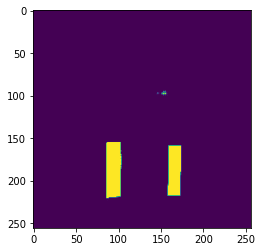

In [ ]:
plt.imshow(predict_imgggg[7][:,:,0])

In [ ]:
count = 0
dice_sum = 0
for image, label in zip(predict_imgggg, y_test):
    # print(count)
    # print(image.shape)
    # print(label.shape)
    dice = dice_coef(label, image)
    # print(dice)
    # print(count)
    dice_sum+= dice
    
    count+=1
dice_average = dice_sum/count
print("dice_average :",  dice_average)

m = MeanIoU(num_classes=2)
m.update_state(y_test, predict_imgggg)
print("Mean IoU :",m.result().numpy())

dice_average : tf.Tensor(0.7714141, shape=(), dtype=float32)
Mean IoU : 0.766996
